We compare linear models for classification with and without noise injection :
Results are reported on 
- MNIST
- MNIST 1000 samples
- MNIST 100 samples


In [110]:
from __future__ import print_function
from __future__ import division

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

In [111]:
from keras.datasets import mnist, cifar10

# classification data
nb_classes = 10
batch_size = 64

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
img_rows, img_cols  = x_train.shape[1:]
dim = img_rows * img_cols 
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]

x_train = x_train.reshape(nb_train, dim)
x_test = x_test.reshape(nb_test, dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [112]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc


def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
       # cov = tf.eye(dim, dtype='float32')
        #sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        sample = tf.distributions.Normal(loc=tf.zeros(shape=[dim]),scale= tf.ones(shape=[dim])).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        #cov =  tf.eye(dim, dtype='float32')
        #sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        sample = tf.distributions.Normal(loc=tf.zeros(shape=[dim]),scale= tf.ones(shape=[dim])).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x)
        log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)
        


class Linear_Model_l2:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x)
        log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=x, labels=self.Y) + l *  tf.nn.l2_loss(self.W)
        self.mean_log_loss = tf.reduce_mean(log_loss)        

In [113]:
# p = 0.5

# X = tf.placeholder(tf.float32, [None, dim])
# sample = tf.contrib.distributions.Bernoulli(probs=p, dtype='float32').sample(tf.shape(X))

# with tf.Session() as sess:
#     idx = np.random.randint(nb_train, size=batch_size)

#     sess.run(tf.global_variables_initializer())
#     sample = sess.run(sample, feed_dict={X : x_train[idx]})

In [124]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    acts1 = []

    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
        acts1.append(act1)

    return all_accuracies,acts1

def training_l2(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    acts1 = []

    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model_l2(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
        acts1.append(act1)

    return all_accuracies,acts1


max_iters = 8000
lambdas = [1e-8,1e-6,1e-4,1e-2,1e-1,1e-0]


print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)


print('#### weight decay ####')
acc_l2, act1_l2 = training_l2(lambdas,None, max_iters)


#### No dropout ####
Lamb None
Iteration: 0, 2.308
Accuracy: 0.230
Iteration: 200, 0.515
Accuracy: 0.870
Iteration: 400, 0.427
Accuracy: 0.892
Iteration: 600, 0.449
Accuracy: 0.903
Iteration: 800, 0.447
Accuracy: 0.908
Iteration: 1000, 0.321
Accuracy: 0.909
Iteration: 1200, 0.331
Accuracy: 0.913
Iteration: 1400, 0.238
Accuracy: 0.916
Iteration: 1600, 0.397
Accuracy: 0.918
Iteration: 1800, 0.371
Accuracy: 0.916
Iteration: 2000, 0.367
Accuracy: 0.921
Iteration: 2200, 0.342
Accuracy: 0.921
Iteration: 2400, 0.125
Accuracy: 0.920
Iteration: 2600, 0.270
Accuracy: 0.922
Iteration: 2800, 0.410
Accuracy: 0.921
Iteration: 3000, 0.497
Accuracy: 0.922
Iteration: 3200, 0.284
Accuracy: 0.925
Iteration: 3400, 0.281
Accuracy: 0.921
Iteration: 3600, 0.424
Accuracy: 0.923
Iteration: 3800, 0.280
Accuracy: 0.923
Iteration: 4000, 0.351
Accuracy: 0.923
Iteration: 4200, 0.429
Accuracy: 0.924
Iteration: 4400, 0.139
Accuracy: 0.924
Iteration: 4600, 0.199
Accuracy: 0.924
Iteration: 4800, 0.178
Accuracy: 0.924
I

Iteration: 1800, 0.537
Accuracy: 0.909
Iteration: 2000, 0.279
Accuracy: 0.910
Iteration: 2200, 0.530
Accuracy: 0.908
Iteration: 2400, 0.326
Accuracy: 0.913
Iteration: 2600, 0.433
Accuracy: 0.911
Iteration: 2800, 0.369
Accuracy: 0.912
Iteration: 3000, 0.381
Accuracy: 0.914
Iteration: 3200, 0.463
Accuracy: 0.909
Iteration: 3400, 0.396
Accuracy: 0.913
Iteration: 3600, 0.392
Accuracy: 0.913
Iteration: 3800, 0.383
Accuracy: 0.911
Iteration: 4000, 0.383
Accuracy: 0.914
Iteration: 4200, 0.294
Accuracy: 0.915
Iteration: 4400, 0.802
Accuracy: 0.912
Iteration: 4600, 0.527
Accuracy: 0.914
Iteration: 4800, 0.302
Accuracy: 0.914
Iteration: 5000, 0.237
Accuracy: 0.914
Iteration: 5200, 0.513
Accuracy: 0.915
Iteration: 5400, 0.177
Accuracy: 0.915
Iteration: 5600, 0.631
Accuracy: 0.915
Iteration: 5800, 0.229
Accuracy: 0.916
Iteration: 6000, 0.288
Accuracy: 0.917
Iteration: 6200, 0.509
Accuracy: 0.917
Iteration: 6400, 0.370
Accuracy: 0.917
Iteration: 6600, 0.465
Accuracy: 0.918
Iteration: 6800, 0.407
Ac

Iteration: 3600, 0.322
Accuracy: 0.922
Iteration: 3800, 0.318
Accuracy: 0.923
Iteration: 4000, 0.252
Accuracy: 0.924
Iteration: 4200, 0.225
Accuracy: 0.924
Iteration: 4400, 0.293
Accuracy: 0.924
Iteration: 4600, 0.513
Accuracy: 0.921
Iteration: 4800, 0.505
Accuracy: 0.923
Iteration: 5000, 0.382
Accuracy: 0.924
Iteration: 5200, 0.334
Accuracy: 0.924
Iteration: 5400, 0.135
Accuracy: 0.923
Iteration: 5600, 0.192
Accuracy: 0.926
Iteration: 5800, 0.229
Accuracy: 0.925
Iteration: 6000, 0.189
Accuracy: 0.925
Iteration: 6200, 0.288
Accuracy: 0.926
Iteration: 6400, 0.340
Accuracy: 0.926
Iteration: 6600, 0.206
Accuracy: 0.926
Iteration: 6800, 0.237
Accuracy: 0.925
Iteration: 7000, 0.496
Accuracy: 0.927
Iteration: 7200, 0.177
Accuracy: 0.925
Iteration: 7400, 0.244
Accuracy: 0.927
Iteration: 7600, 0.397
Accuracy: 0.927
Iteration: 7800, 0.110
Accuracy: 0.925
Lamb 0.1
Iteration: 0, 2.313
Accuracy: 0.175
Iteration: 200, 0.540
Accuracy: 0.870
Iteration: 400, 0.790
Accuracy: 0.892
Iteration: 600, 0.498

Iteration: 5600, 0.369
Accuracy: 0.925
Iteration: 5800, 0.177
Accuracy: 0.924
Iteration: 6000, 0.360
Accuracy: 0.925
Iteration: 6200, 0.489
Accuracy: 0.923
Iteration: 6400, 0.426
Accuracy: 0.925
Iteration: 6600, 0.212
Accuracy: 0.925
Iteration: 6800, 0.206
Accuracy: 0.926
Iteration: 7000, 0.339
Accuracy: 0.925
Iteration: 7200, 0.280
Accuracy: 0.927
Iteration: 7400, 0.539
Accuracy: 0.926
Iteration: 7600, 0.191
Accuracy: 0.926
Iteration: 7800, 0.194
Accuracy: 0.925
Lamb 0.01
Iteration: 0, 2.316
Accuracy: 0.209
Iteration: 200, 0.502
Accuracy: 0.874
Iteration: 400, 0.537
Accuracy: 0.891
Iteration: 600, 0.591
Accuracy: 0.901
Iteration: 800, 0.336
Accuracy: 0.910
Iteration: 1000, 0.373
Accuracy: 0.909
Iteration: 1200, 0.330
Accuracy: 0.915
Iteration: 1400, 0.290
Accuracy: 0.915
Iteration: 1600, 0.508
Accuracy: 0.917
Iteration: 1800, 0.441
Accuracy: 0.916
Iteration: 2000, 0.338
Accuracy: 0.918
Iteration: 2200, 0.352
Accuracy: 0.918
Iteration: 2400, 0.211
Accuracy: 0.920
Iteration: 2600, 0.185

Iteration: 7600, 0.194
Accuracy: 0.927
Iteration: 7800, 0.258
Accuracy: 0.926
Lamb 0.0001
Iteration: 0, 2.296
Accuracy: 0.238
Iteration: 200, 0.536
Accuracy: 0.875
Iteration: 400, 0.315
Accuracy: 0.895
Iteration: 600, 0.473
Accuracy: 0.902
Iteration: 800, 0.347
Accuracy: 0.908
Iteration: 1000, 0.433
Accuracy: 0.911
Iteration: 1200, 0.437
Accuracy: 0.913
Iteration: 1400, 0.470
Accuracy: 0.914
Iteration: 1600, 0.324
Accuracy: 0.914
Iteration: 1800, 0.131
Accuracy: 0.917
Iteration: 2000, 0.343
Accuracy: 0.917
Iteration: 2200, 0.279
Accuracy: 0.918
Iteration: 2400, 0.166
Accuracy: 0.919
Iteration: 2600, 0.723
Accuracy: 0.919
Iteration: 2800, 0.298
Accuracy: 0.922
Iteration: 3000, 0.359
Accuracy: 0.922
Iteration: 3200, 0.319
Accuracy: 0.920
Iteration: 3400, 0.189
Accuracy: 0.921
Iteration: 3600, 0.163
Accuracy: 0.921
Iteration: 3800, 0.251
Accuracy: 0.922
Iteration: 4000, 0.130
Accuracy: 0.923
Iteration: 4200, 0.118
Accuracy: 0.924
Iteration: 4400, 0.252
Accuracy: 0.924
Iteration: 4600, 0.2

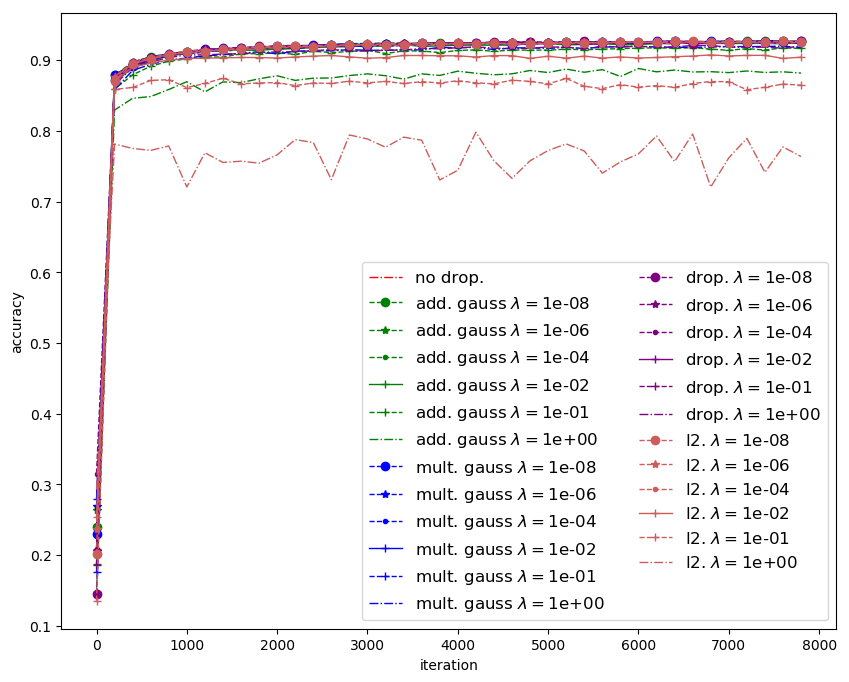

In [132]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','-+', '--+', '-.', ':']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
    
for i, series in enumerate(acc_l2):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='indianred', linewidth=1,
            label=r'l2. $\lambda=$%.0e' % lambdas[i])

    
    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 12})
plt.show()

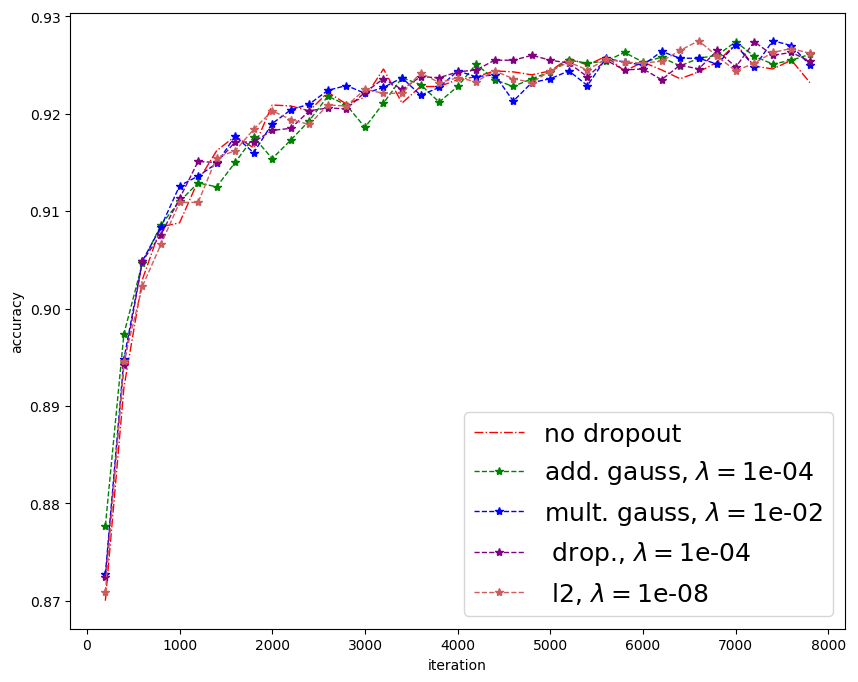

In [133]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), acc_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--']


best_add = np.argmax([np.max(accs) for accs in acc_add])

ax.plot(np.arange(200, max_iters, 200), acc_add[best_add][1:],
            line_styles[1], color='green', linewidth=1,
            label=r'add. gauss, $\lambda=$%.0e' % lambdas[best_add])

best_mult = np.argmax([np.max(accs) for accs in acc_mult])

ax.plot(np.arange(200, max_iters, 200), acc_mult[best_mult][1:],
            line_styles[1], color='blue', linewidth=1,
            label=r'mult. gauss, $\lambda=$%.0e' % lambdas[best_mult])

best_drop = np.argmax([np.max(accs) for accs in acc_drop])

ax.plot(np.arange(200, max_iters, 200), acc_drop[best_drop][1:],
            line_styles[1], color='purple', linewidth=1,
            label=r' drop., $\lambda=$%.0e' % lambdas[best_drop])


best_l2 = np.argmax([np.max(accs) for accs in acc_l2])

ax.plot(np.arange(200, max_iters, 200), acc_l2[best_l2][1:],
            line_styles[1], color='indianred', linewidth=1,
            label=r' l2, $\lambda=$%.0e' % lambdas[best_l2])


ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

plt.legend(prop={'size': 18})
plt.show()

In [134]:
[np.max(accs) for accs in acc_linear]

[0.9272]

In [135]:
[np.max(accs) for accs in acc_add]

[0.9272, 0.9269, 0.9274, 0.9245, 0.9176, 0.8882]

In [136]:
[np.max(accs) for accs in acc_mult]

[0.9271, 0.927, 0.9269, 0.9275, 0.9262, 0.9199]

In [137]:
[np.max(accs) for accs in acc_drop]

[0.9267, 0.9268, 0.9274, 0.9265, 0.9265, 0.9209]

In [138]:
[np.max(accs) for accs in acc_l2]

[0.9275, 0.9268, 0.9262, 0.9075, 0.8744, 0.7982]

IndexError: list index out of range

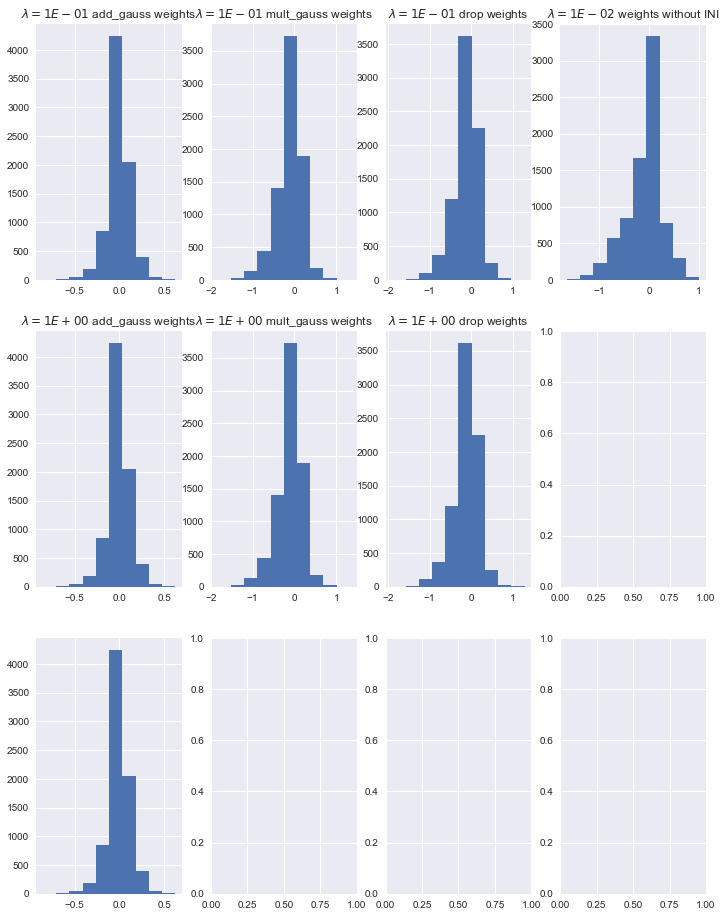

In [42]:
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % lambdas[0])

_ = axes[0][0].hist(act1_add[1].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[0][1].hist(act1_mult[1].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[0][2].hist(act1_drop[1].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
_ = axes[2][0].hist(act1_add[1].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[3])
_ = axes[2][1].hist(act1_mult[1].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[3])
_ = axes[2][2].hist(act1_drop[1].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[3])
plt.show()

In [81]:
nb_train=1000
x_train = x_train[0:nb_train,]
y_train=y_train[0:nb_train]
x_train.shape

(1000, 784)

In [57]:

max_iters = 10000
lambdas = [1e-8,1e-6,1e-4,1e-2,1e-1,1e-0]


print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)

print('#### weight decay ####')
acc_l2, act1_l2 = training_l2(lambdas,None, max_iters)


#### No dropout ####
Lamb None
Iteration: 0, 2.306
Accuracy: 0.334
Iteration: 200, 0.491
Accuracy: 0.834
Iteration: 400, 0.247
Accuracy: 0.860
Iteration: 600, 0.330
Accuracy: 0.868
Iteration: 800, 0.208
Accuracy: 0.870
Iteration: 1000, 0.125
Accuracy: 0.868
Iteration: 1200, 0.147
Accuracy: 0.868
Iteration: 1400, 0.071
Accuracy: 0.865
Iteration: 1600, 0.098
Accuracy: 0.866
Iteration: 1800, 0.058
Accuracy: 0.864
Iteration: 2000, 0.063
Accuracy: 0.866
Iteration: 2200, 0.064
Accuracy: 0.864
Iteration: 2400, 0.054
Accuracy: 0.863
Iteration: 2600, 0.045
Accuracy: 0.862
Iteration: 2800, 0.046
Accuracy: 0.864
Iteration: 3000, 0.031
Accuracy: 0.862
Iteration: 3200, 0.030
Accuracy: 0.861
Iteration: 3400, 0.024
Accuracy: 0.863
Iteration: 3600, 0.027
Accuracy: 0.860
Iteration: 3800, 0.021
Accuracy: 0.861
Iteration: 4000, 0.020
Accuracy: 0.861
Iteration: 4200, 0.012
Accuracy: 0.860
Iteration: 4400, 0.018
Accuracy: 0.861
Iteration: 4600, 0.015
Accuracy: 0.862
Iteration: 4800, 0.012
Accuracy: 0.860
I

Iteration: 1800, 0.105
Accuracy: 0.865
Iteration: 2000, 0.114
Accuracy: 0.864
Iteration: 2200, 0.111
Accuracy: 0.866
Iteration: 2400, 0.071
Accuracy: 0.865
Iteration: 2600, 0.080
Accuracy: 0.863
Iteration: 2800, 0.064
Accuracy: 0.861
Iteration: 3000, 0.075
Accuracy: 0.862
Iteration: 3200, 0.033
Accuracy: 0.861
Iteration: 3400, 0.046
Accuracy: 0.861
Iteration: 3600, 0.029
Accuracy: 0.862
Iteration: 3800, 0.039
Accuracy: 0.863
Iteration: 4000, 0.032
Accuracy: 0.860
Iteration: 4200, 0.016
Accuracy: 0.860
Iteration: 4400, 0.030
Accuracy: 0.861
Iteration: 4600, 0.029
Accuracy: 0.862
Iteration: 4800, 0.026
Accuracy: 0.860
Iteration: 5000, 0.019
Accuracy: 0.859
Iteration: 5200, 0.023
Accuracy: 0.863
Iteration: 5400, 0.022
Accuracy: 0.860
Iteration: 5600, 0.029
Accuracy: 0.861
Iteration: 5800, 0.019
Accuracy: 0.864
Iteration: 6000, 0.042
Accuracy: 0.862
Iteration: 6200, 0.018
Accuracy: 0.861
Iteration: 6400, 0.025
Accuracy: 0.862
Iteration: 6600, 0.006
Accuracy: 0.860
Iteration: 6800, 0.008
Ac

Iteration: 3600, 0.024
Accuracy: 0.864
Iteration: 3800, 0.022
Accuracy: 0.863
Iteration: 4000, 0.015
Accuracy: 0.861
Iteration: 4200, 0.010
Accuracy: 0.862
Iteration: 4400, 0.010
Accuracy: 0.862
Iteration: 4600, 0.010
Accuracy: 0.860
Iteration: 4800, 0.007
Accuracy: 0.861
Iteration: 5000, 0.011
Accuracy: 0.862
Iteration: 5200, 0.010
Accuracy: 0.860
Iteration: 5400, 0.007
Accuracy: 0.861
Iteration: 5600, 0.008
Accuracy: 0.860
Iteration: 5800, 0.007
Accuracy: 0.861
Iteration: 6000, 0.007
Accuracy: 0.861
Iteration: 6200, 0.005
Accuracy: 0.860
Iteration: 6400, 0.006
Accuracy: 0.862
Iteration: 6600, 0.004
Accuracy: 0.859
Iteration: 6800, 0.005
Accuracy: 0.859
Iteration: 7000, 0.004
Accuracy: 0.860
Iteration: 7200, 0.004
Accuracy: 0.858
Iteration: 7400, 0.003
Accuracy: 0.859
Iteration: 7600, 0.004
Accuracy: 0.859
Iteration: 7800, 0.003
Accuracy: 0.859
Iteration: 8000, 0.002
Accuracy: 0.859
Iteration: 8200, 0.002
Accuracy: 0.860
Iteration: 8400, 0.002
Accuracy: 0.859
Iteration: 8600, 0.002
Ac

Iteration: 5600, 0.172
Accuracy: 0.868
Iteration: 5800, 0.177
Accuracy: 0.867
Iteration: 6000, 0.170
Accuracy: 0.867
Iteration: 6200, 0.085
Accuracy: 0.867
Iteration: 6400, 0.222
Accuracy: 0.868
Iteration: 6600, 0.175
Accuracy: 0.869
Iteration: 6800, 0.198
Accuracy: 0.868
Iteration: 7000, 0.226
Accuracy: 0.867
Iteration: 7200, 0.168
Accuracy: 0.867
Iteration: 7400, 0.106
Accuracy: 0.866
Iteration: 7600, 0.171
Accuracy: 0.866
Iteration: 7800, 0.131
Accuracy: 0.867
Iteration: 8000, 0.166
Accuracy: 0.867
Iteration: 8200, 0.069
Accuracy: 0.868
Iteration: 8400, 0.128
Accuracy: 0.863
Iteration: 8600, 0.265
Accuracy: 0.868
Iteration: 8800, 0.062
Accuracy: 0.870
Iteration: 9000, 0.160
Accuracy: 0.869
Iteration: 9200, 0.050
Accuracy: 0.871
Iteration: 9400, 0.222
Accuracy: 0.870
Iteration: 9600, 0.125
Accuracy: 0.866
Iteration: 9800, 0.142
Accuracy: 0.868
#### dropout ####
Lamb 1e-08
Iteration: 0, 2.303
Accuracy: 0.235
Iteration: 200, 0.532
Accuracy: 0.834
Iteration: 400, 0.389
Accuracy: 0.860
I

Iteration: 7600, 0.003
Accuracy: 0.858
Iteration: 7800, 0.002
Accuracy: 0.859
Iteration: 8000, 0.002
Accuracy: 0.859
Iteration: 8200, 0.003
Accuracy: 0.859
Iteration: 8400, 0.003
Accuracy: 0.860
Iteration: 8600, 0.001
Accuracy: 0.858
Iteration: 8800, 0.001
Accuracy: 0.859
Iteration: 9000, 0.002
Accuracy: 0.858
Iteration: 9200, 0.001
Accuracy: 0.858
Iteration: 9400, 0.001
Accuracy: 0.858
Iteration: 9600, 0.002
Accuracy: 0.859
Iteration: 9800, 0.002
Accuracy: 0.858
Lamb 0.1
Iteration: 0, 2.306
Accuracy: 0.258
Iteration: 200, 0.508
Accuracy: 0.831
Iteration: 400, 0.331
Accuracy: 0.858
Iteration: 600, 0.259
Accuracy: 0.867
Iteration: 800, 0.187
Accuracy: 0.865
Iteration: 1000, 0.238
Accuracy: 0.869
Iteration: 1200, 0.129
Accuracy: 0.869
Iteration: 1400, 0.099
Accuracy: 0.867
Iteration: 1600, 0.099
Accuracy: 0.868
Iteration: 1800, 0.080
Accuracy: 0.867
Iteration: 2000, 0.062
Accuracy: 0.867
Iteration: 2200, 0.076
Accuracy: 0.865
Iteration: 2400, 0.072
Accuracy: 0.865
Iteration: 2600, 0.068


Iteration: 9600, 0.002
Accuracy: 0.859
Iteration: 9800, 0.002
Accuracy: 0.858
Lamb 0.0001
Iteration: 0, 2.303
Accuracy: 0.304
Iteration: 200, 0.493
Accuracy: 0.836
Iteration: 400, 0.352
Accuracy: 0.856
Iteration: 600, 0.231
Accuracy: 0.861
Iteration: 800, 0.184
Accuracy: 0.865
Iteration: 1000, 0.160
Accuracy: 0.864
Iteration: 1200, 0.130
Accuracy: 0.868
Iteration: 1400, 0.155
Accuracy: 0.867
Iteration: 1600, 0.069
Accuracy: 0.865
Iteration: 1800, 0.093
Accuracy: 0.865
Iteration: 2000, 0.054
Accuracy: 0.866
Iteration: 2200, 0.082
Accuracy: 0.866
Iteration: 2400, 0.081
Accuracy: 0.866
Iteration: 2600, 0.064
Accuracy: 0.862
Iteration: 2800, 0.071
Accuracy: 0.862
Iteration: 3000, 0.062
Accuracy: 0.861
Iteration: 3200, 0.053
Accuracy: 0.863
Iteration: 3400, 0.046
Accuracy: 0.863
Iteration: 3600, 0.047
Accuracy: 0.862
Iteration: 3800, 0.032
Accuracy: 0.861
Iteration: 4000, 0.036
Accuracy: 0.864
Iteration: 4200, 0.048
Accuracy: 0.863
Iteration: 4400, 0.040
Accuracy: 0.862
Iteration: 4600, 0.0

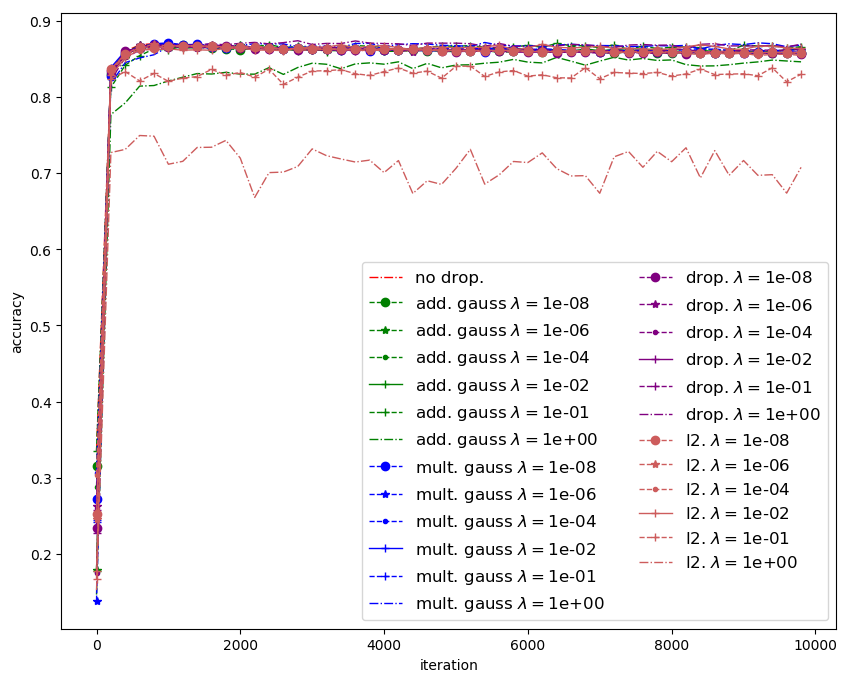

In [58]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','-+', '--+', '-.', ':']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
    
for i, series in enumerate(acc_l2):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='indianred', linewidth=1,
            label=r'l2. $\lambda=$%.0e' % lambdas[i])

    
    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 12})
plt.show()

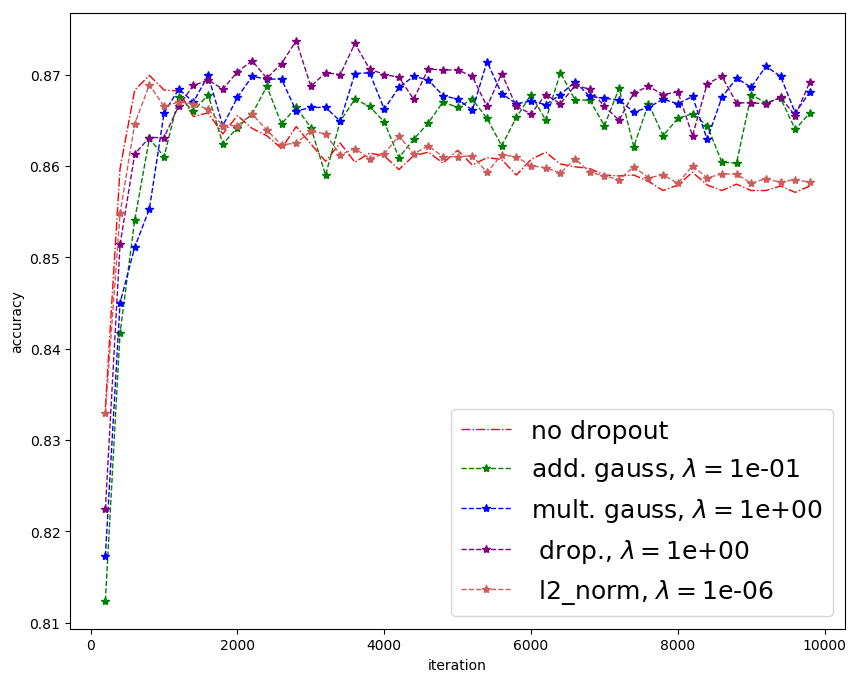

In [59]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), acc_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--']


best_add = np.argmax([np.max(accs) for accs in acc_add])

ax.plot(np.arange(200, max_iters, 200), acc_add[best_add][1:],
            line_styles[1], color='green', linewidth=1,
            label=r'add. gauss, $\lambda=$%.0e' % lambdas[best_add])

best_mult = np.argmax([np.max(accs) for accs in acc_mult])

ax.plot(np.arange(200, max_iters, 200), acc_mult[best_mult][1:],
            line_styles[1], color='blue', linewidth=1,
            label=r'mult. gauss, $\lambda=$%.0e' % lambdas[best_mult])

best_drop = np.argmax([np.max(accs) for accs in acc_drop])

ax.plot(np.arange(200, max_iters, 200), acc_drop[best_drop][1:],
            line_styles[1], color='purple', linewidth=1,
            label=r' drop., $\lambda=$%.0e' % lambdas[best_drop])


best_l2 = np.argmax([np.max(accs) for accs in acc_l2])

ax.plot(np.arange(200, max_iters, 200), acc_l2[best_l2][1:],
            line_styles[1], color='indianred', linewidth=1,
            label=r' l2, $\lambda=$%.0e' % lambdas[best_l2])


ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

plt.legend(prop={'size': 18})
plt.show()

In [60]:
[np.max(accs) for accs in acc_linear]

[0.8699]

In [61]:
[np.max(accs) for accs in acc_add]

[0.8687, 0.868, 0.8688, 0.8667, 0.8702, 0.852]

In [62]:
[np.max(accs) for accs in acc_mult]

[0.8708, 0.8705, 0.8684, 0.8686, 0.8691, 0.8714]

In [63]:
[np.max(accs) for accs in acc_drop]

[0.868, 0.8675, 0.8679, 0.8678, 0.8688, 0.8737]

In [64]:
[np.max(accs) for accs in acc_l2]

[0.8672, 0.8689, 0.8678, 0.8689, 0.8404, 0.7493]

In [98]:
nb_train=100
x_train = x_train[0:nb_train,]
y_train=y_train[0:nb_train]
batch_size = 64
x_train.shape


(100, 784)

In [99]:
max_iters = 10000
lambdas = [1e-8,1e-6,1e-4,1e-2,1e-1,1e-0]


print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)

print('#### weight decay ####')
acc_l2, act1_l2 = training_l2(lambdas,None, max_iters)


#### No dropout ####
Lamb None
Iteration: 0, 2.302
Accuracy: 0.178
Iteration: 200, 0.137
Accuracy: 0.683
Iteration: 400, 0.042
Accuracy: 0.687
Iteration: 600, 0.028
Accuracy: 0.685
Iteration: 800, 0.017
Accuracy: 0.686
Iteration: 1000, 0.010
Accuracy: 0.685
Iteration: 1200, 0.009
Accuracy: 0.684
Iteration: 1400, 0.006
Accuracy: 0.684
Iteration: 1600, 0.005
Accuracy: 0.684
Iteration: 1800, 0.004
Accuracy: 0.684
Iteration: 2000, 0.003
Accuracy: 0.684
Iteration: 2200, 0.003
Accuracy: 0.684
Iteration: 2400, 0.003
Accuracy: 0.684
Iteration: 2600, 0.002
Accuracy: 0.684
Iteration: 2800, 0.002
Accuracy: 0.685
Iteration: 3000, 0.002
Accuracy: 0.685
Iteration: 3200, 0.001
Accuracy: 0.684
Iteration: 3400, 0.001
Accuracy: 0.684
Iteration: 3600, 0.001
Accuracy: 0.684
Iteration: 3800, 0.001
Accuracy: 0.684
Iteration: 4000, 0.001
Accuracy: 0.684
Iteration: 4200, 0.001
Accuracy: 0.684
Iteration: 4400, 0.001
Accuracy: 0.684
Iteration: 4600, 0.001
Accuracy: 0.684
Iteration: 4800, 0.001
Accuracy: 0.684
I

Iteration: 1800, 0.005
Accuracy: 0.680
Iteration: 2000, 0.004
Accuracy: 0.681
Iteration: 2200, 0.003
Accuracy: 0.680
Iteration: 2400, 0.003
Accuracy: 0.681
Iteration: 2600, 0.002
Accuracy: 0.680
Iteration: 2800, 0.001
Accuracy: 0.680
Iteration: 3000, 0.002
Accuracy: 0.681
Iteration: 3200, 0.002
Accuracy: 0.679
Iteration: 3400, 0.001
Accuracy: 0.680
Iteration: 3600, 0.001
Accuracy: 0.681
Iteration: 3800, 0.001
Accuracy: 0.681
Iteration: 4000, 0.001
Accuracy: 0.680
Iteration: 4200, 0.001
Accuracy: 0.681
Iteration: 4400, 0.001
Accuracy: 0.680
Iteration: 4600, 0.001
Accuracy: 0.680
Iteration: 4800, 0.001
Accuracy: 0.680
Iteration: 5000, 0.000
Accuracy: 0.679
Iteration: 5200, 0.000
Accuracy: 0.680
Iteration: 5400, 0.000
Accuracy: 0.680
Iteration: 5600, 0.000
Accuracy: 0.679
Iteration: 5800, 0.000
Accuracy: 0.680
Iteration: 6000, 0.000
Accuracy: 0.680
Iteration: 6200, 0.000
Accuracy: 0.679
Iteration: 6400, 0.000
Accuracy: 0.680
Iteration: 6600, 0.000
Accuracy: 0.680
Iteration: 6800, 0.000
Ac

Iteration: 3600, 0.001
Accuracy: 0.683
Iteration: 3800, 0.001
Accuracy: 0.683
Iteration: 4000, 0.001
Accuracy: 0.683
Iteration: 4200, 0.001
Accuracy: 0.683
Iteration: 4400, 0.001
Accuracy: 0.683
Iteration: 4600, 0.000
Accuracy: 0.683
Iteration: 4800, 0.001
Accuracy: 0.683
Iteration: 5000, 0.000
Accuracy: 0.683
Iteration: 5200, 0.000
Accuracy: 0.683
Iteration: 5400, 0.000
Accuracy: 0.683
Iteration: 5600, 0.000
Accuracy: 0.682
Iteration: 5800, 0.000
Accuracy: 0.682
Iteration: 6000, 0.000
Accuracy: 0.683
Iteration: 6200, 0.000
Accuracy: 0.682
Iteration: 6400, 0.000
Accuracy: 0.682
Iteration: 6600, 0.000
Accuracy: 0.682
Iteration: 6800, 0.000
Accuracy: 0.683
Iteration: 7000, 0.000
Accuracy: 0.682
Iteration: 7200, 0.000
Accuracy: 0.682
Iteration: 7400, 0.000
Accuracy: 0.681
Iteration: 7600, 0.000
Accuracy: 0.681
Iteration: 7800, 0.000
Accuracy: 0.682
Iteration: 8000, 0.000
Accuracy: 0.682
Iteration: 8200, 0.000
Accuracy: 0.681
Iteration: 8400, 0.000
Accuracy: 0.682
Iteration: 8600, 0.000
Ac

Iteration: 5600, 0.002
Accuracy: 0.697
Iteration: 5800, 0.011
Accuracy: 0.700
Iteration: 6000, 0.000
Accuracy: 0.697
Iteration: 6200, 0.017
Accuracy: 0.702
Iteration: 6400, 0.006
Accuracy: 0.704
Iteration: 6600, 0.005
Accuracy: 0.699
Iteration: 6800, 0.001
Accuracy: 0.703
Iteration: 7000, 0.000
Accuracy: 0.703
Iteration: 7200, 0.001
Accuracy: 0.700
Iteration: 7400, 0.000
Accuracy: 0.699
Iteration: 7600, 0.007
Accuracy: 0.707
Iteration: 7800, 0.005
Accuracy: 0.703
Iteration: 8000, 0.005
Accuracy: 0.703
Iteration: 8200, 0.002
Accuracy: 0.701
Iteration: 8400, 0.003
Accuracy: 0.705
Iteration: 8600, 0.001
Accuracy: 0.706
Iteration: 8800, 0.000
Accuracy: 0.704
Iteration: 9000, 0.002
Accuracy: 0.704
Iteration: 9200, 0.000
Accuracy: 0.702
Iteration: 9400, 0.000
Accuracy: 0.702
Iteration: 9600, 0.001
Accuracy: 0.709
Iteration: 9800, 0.000
Accuracy: 0.705
#### dropout ####
Lamb 1e-08
Iteration: 0, 2.294
Accuracy: 0.301
Iteration: 200, 0.145
Accuracy: 0.682
Iteration: 400, 0.045
Accuracy: 0.687
I

Iteration: 7600, 0.000
Accuracy: 0.684
Iteration: 7800, 0.000
Accuracy: 0.684
Iteration: 8000, 0.000
Accuracy: 0.684
Iteration: 8200, 0.000
Accuracy: 0.684
Iteration: 8400, 0.000
Accuracy: 0.683
Iteration: 8600, 0.000
Accuracy: 0.683
Iteration: 8800, 0.000
Accuracy: 0.684
Iteration: 9000, 0.000
Accuracy: 0.683
Iteration: 9200, 0.000
Accuracy: 0.683
Iteration: 9400, 0.000
Accuracy: 0.683
Iteration: 9600, 0.000
Accuracy: 0.683
Iteration: 9800, 0.000
Accuracy: 0.683
Lamb 0.1
Iteration: 0, 2.322
Accuracy: 0.229
Iteration: 200, 0.163
Accuracy: 0.685
Iteration: 400, 0.053
Accuracy: 0.684
Iteration: 600, 0.023
Accuracy: 0.687
Iteration: 800, 0.021
Accuracy: 0.687
Iteration: 1000, 0.011
Accuracy: 0.685
Iteration: 1200, 0.010
Accuracy: 0.686
Iteration: 1400, 0.006
Accuracy: 0.686
Iteration: 1600, 0.005
Accuracy: 0.684
Iteration: 1800, 0.005
Accuracy: 0.685
Iteration: 2000, 0.004
Accuracy: 0.684
Iteration: 2200, 0.003
Accuracy: 0.685
Iteration: 2400, 0.003
Accuracy: 0.685
Iteration: 2600, 0.002


Iteration: 9600, 0.000
Accuracy: 0.681
Iteration: 9800, 0.000
Accuracy: 0.680
Lamb 0.0001
Iteration: 0, 2.309
Accuracy: 0.204
Iteration: 200, 0.158
Accuracy: 0.682
Iteration: 400, 0.050
Accuracy: 0.683
Iteration: 600, 0.030
Accuracy: 0.682
Iteration: 800, 0.021
Accuracy: 0.684
Iteration: 1000, 0.015
Accuracy: 0.682
Iteration: 1200, 0.013
Accuracy: 0.682
Iteration: 1400, 0.010
Accuracy: 0.683
Iteration: 1600, 0.009
Accuracy: 0.682
Iteration: 1800, 0.008
Accuracy: 0.681
Iteration: 2000, 0.008
Accuracy: 0.681
Iteration: 2200, 0.008
Accuracy: 0.681
Iteration: 2400, 0.007
Accuracy: 0.681
Iteration: 2600, 0.007
Accuracy: 0.682
Iteration: 2800, 0.007
Accuracy: 0.683
Iteration: 3000, 0.007
Accuracy: 0.681
Iteration: 3200, 0.007
Accuracy: 0.681
Iteration: 3400, 0.006
Accuracy: 0.682
Iteration: 3600, 0.006
Accuracy: 0.681
Iteration: 3800, 0.007
Accuracy: 0.681
Iteration: 4000, 0.006
Accuracy: 0.680
Iteration: 4200, 0.006
Accuracy: 0.680
Iteration: 4400, 0.006
Accuracy: 0.681
Iteration: 4600, 0.0

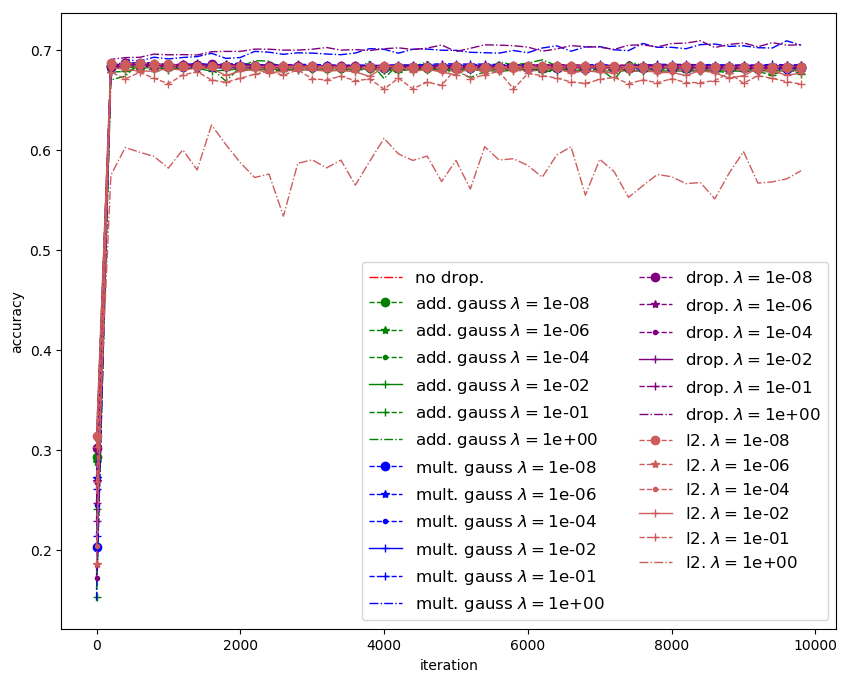

In [102]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','-+', '--+', '-.', ':']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
    
for i, series in enumerate(acc_l2):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='indianred', linewidth=1,
            label=r'l2. $\lambda=$%.0e' % lambdas[i])

    
    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 12})
plt.show()

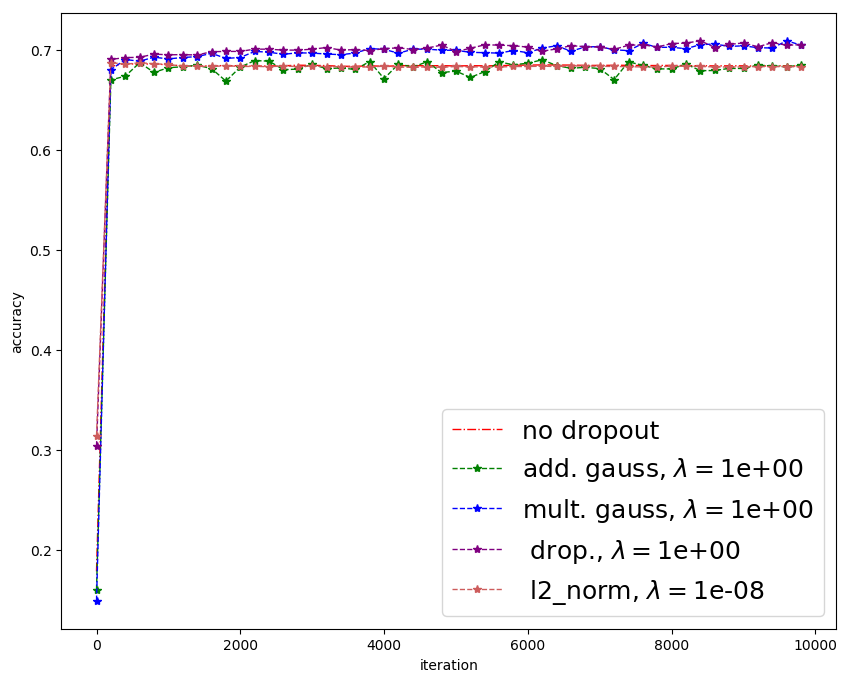

In [103]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0][0:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--']


best_add = np.argmax([np.max(accs) for accs in acc_add])

ax.plot(np.arange(0, max_iters, 200), acc_add[best_add][0:],
            line_styles[1], color='green', linewidth=1,
            label=r'add. gauss, $\lambda=$%.0e' % lambdas[best_add])

best_mult = np.argmax([np.max(accs) for accs in acc_mult])

ax.plot(np.arange(0, max_iters, 200), acc_mult[best_mult][0:],
            line_styles[1], color='blue', linewidth=1,
            label=r'mult. gauss, $\lambda=$%.0e' % lambdas[best_mult])

best_drop = np.argmax([np.max(accs) for accs in acc_drop])

ax.plot(np.arange(0, max_iters, 200), acc_drop[best_drop][0:],
            line_styles[1], color='purple', linewidth=1,
            label=r' drop., $\lambda=$%.0e' % lambdas[best_drop])


best_l2 = np.argmax([np.max(accs) for accs in acc_l2])

ax.plot(np.arange(0, max_iters, 200), acc_l2[best_l2][0:],
            line_styles[1], color='indianred', linewidth=1,
            label=r' l2_norm, $\lambda=$%.0e' % lambdas[best_l2])


ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

plt.legend(prop={'size': 18})
plt.show()

In [105]:
[np.max(accs) for accs in acc_linear]

[0.6867]

In [106]:
[np.max(accs) for accs in acc_add]

[0.6854, 0.6872, 0.6836, 0.6835, 0.6845, 0.6902]

In [107]:
[np.max(accs) for accs in acc_mult]

[0.6866, 0.686, 0.6858, 0.6868, 0.6873, 0.7092]

In [108]:
[np.max(accs) for accs in acc_drop]

[0.6871, 0.6858, 0.6862, 0.6877, 0.6867, 0.7093]

In [109]:
[np.max(accs) for accs in acc_l2]

[0.6875, 0.6857, 0.6836, 0.6844, 0.6816, 0.625]

In [30]:
from __future__ import print_function
from __future__ import division

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

In [31]:
from keras.datasets import mnist, cifar10

# classification data
nb_classes = 10
batch_size = 128

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
img_rows, img_cols, nb_channels  = x_train.shape[1:]
dim = img_rows * img_cols * nb_channels
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]

x_train = x_train.reshape(nb_train, dim)
x_test = x_test.reshape(nb_test, dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [32]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, W) + b, lambda : tf.matmul(x, W) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x)
        log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [34]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []


    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred = sess.run(model.probs,
                                    feed_dict={model.X : x_test, model.train : False})
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)

    return all_accuracies

max_iters = 8000
lambdas = [1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop = training(lambdas, 'drop', max_iters)

#### No dropout ####
Lamb None
Iteration: 0, 2.330
Accuracy: 0.100
Iteration: 200, 1.939
Accuracy: 0.342
Iteration: 400, 1.644
Accuracy: 0.344
Iteration: 600, 1.829
Accuracy: 0.372
Iteration: 800, 1.946
Accuracy: 0.358
Iteration: 1000, 1.685
Accuracy: 0.373
Iteration: 1200, 1.734
Accuracy: 0.383
Iteration: 1400, 1.709
Accuracy: 0.386
Iteration: 1600, 1.874
Accuracy: 0.338
Iteration: 1800, 1.715
Accuracy: 0.380
Iteration: 2000, 1.734
Accuracy: 0.389
Iteration: 2200, 1.756
Accuracy: 0.366
Iteration: 2400, 1.740
Accuracy: 0.393
Iteration: 2600, 1.607
Accuracy: 0.384
Iteration: 2800, 1.725
Accuracy: 0.383
Iteration: 3000, 1.752
Accuracy: 0.382
Iteration: 3200, 1.646
Accuracy: 0.389
Iteration: 3400, 1.789
Accuracy: 0.389
Iteration: 3600, 1.628
Accuracy: 0.354
Iteration: 3800, 1.755
Accuracy: 0.380
Iteration: 4000, 1.640
Accuracy: 0.372
Iteration: 4200, 1.898
Accuracy: 0.377
Iteration: 4400, 1.699
Accuracy: 0.382
Iteration: 4600, 1.498
Accuracy: 0.390
Iteration: 4800, 1.717
Accuracy: 0.368
I

Iteration: 1600, 1.679
Accuracy: 0.383
Iteration: 1800, 1.866
Accuracy: 0.382
Iteration: 2000, 1.828
Accuracy: 0.374
Iteration: 2200, 1.948
Accuracy: 0.383
Iteration: 2400, 1.649
Accuracy: 0.376
Iteration: 2600, 1.727
Accuracy: 0.384
Iteration: 2800, 1.882
Accuracy: 0.370
Iteration: 3000, 1.741
Accuracy: 0.366
Iteration: 3200, 1.923
Accuracy: 0.357
Iteration: 3400, 1.878
Accuracy: 0.360
Iteration: 3600, 1.933
Accuracy: 0.377
Iteration: 3800, 1.694
Accuracy: 0.388
Iteration: 4000, 1.804
Accuracy: 0.361
Iteration: 4200, 1.902
Accuracy: 0.361
Iteration: 4400, 1.921
Accuracy: 0.379
Iteration: 4600, 1.754
Accuracy: 0.373
Iteration: 4800, 1.819
Accuracy: 0.371
Iteration: 5000, 1.608
Accuracy: 0.382
Iteration: 5200, 2.021
Accuracy: 0.367
Iteration: 5400, 1.939
Accuracy: 0.356
Iteration: 5600, 1.817
Accuracy: 0.395
Iteration: 5800, 1.901
Accuracy: 0.377
Iteration: 6000, 1.818
Accuracy: 0.374
Iteration: 6200, 1.913
Accuracy: 0.387
Iteration: 6400, 1.643
Accuracy: 0.381
Iteration: 6600, 1.856
Ac

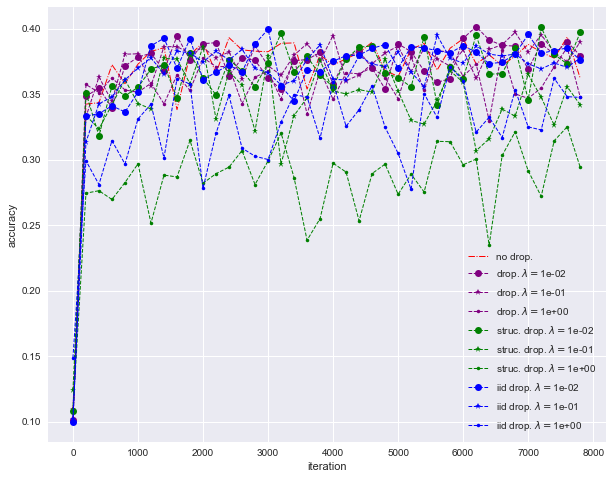

In [37]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.']

#'--+'
    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'iid drop. $\lambda=$%.0e' % lambdas[i])


    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [2]:
from __future__ import print_function
from __future__ import division

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

In [3]:
from keras.datasets import mnist, cifar100

# classification data
nb_classes = 100
batch_size = 128

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# input image dimensions
img_rows, img_cols, nb_channels  = x_train.shape[1:]
dim = img_rows * img_cols * nb_channels
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]

x_train = x_train.reshape(nb_train, dim)
x_test = x_test.reshape(nb_test, dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [4]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, W) + b, lambda : tf.matmul(x, W) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [5]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []


    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred = sess.run(model.probs,
                                    feed_dict={model.X : x_test, model.train : False})
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)

    return all_accuracies

max_iters = 8000
lambdas = [0,1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop = training(lambdas, 'drop', max_iters)

#### No dropout ####
Lamb None
Iteration: 0, 0.699
Accuracy: 0.009
Iteration: 200, 0.058
Accuracy: 0.072
Iteration: 400, 0.057
Accuracy: 0.088
Iteration: 600, 0.059
Accuracy: 0.100
Iteration: 800, 0.056
Accuracy: 0.093
Iteration: 1000, 0.060
Accuracy: 0.109
Iteration: 1200, 0.056
Accuracy: 0.113
Iteration: 1400, 0.058
Accuracy: 0.106
Iteration: 1600, 0.058
Accuracy: 0.118
Iteration: 1800, 0.062
Accuracy: 0.114
Iteration: 2000, 0.057
Accuracy: 0.125
Iteration: 2200, 0.056
Accuracy: 0.122
Iteration: 2400, 0.056
Accuracy: 0.117
Iteration: 2600, 0.055
Accuracy: 0.126
Iteration: 2800, 0.057
Accuracy: 0.135
Iteration: 3000, 0.055
Accuracy: 0.123
Iteration: 3200, 0.053
Accuracy: 0.123
Iteration: 3400, 0.057
Accuracy: 0.125
Iteration: 3600, 0.053
Accuracy: 0.120
Iteration: 3800, 0.053
Accuracy: 0.127
Iteration: 4000, 0.051
Accuracy: 0.124
Iteration: 4200, 0.054
Accuracy: 0.116
Iteration: 4400, 0.054
Accuracy: 0.134
Iteration: 4600, 0.051
Accuracy: 0.129
Iteration: 4800, 0.055
Accuracy: 0.119
I

Iteration: 4800, 0.056
Accuracy: 0.111
Iteration: 5000, 0.055
Accuracy: 0.116
Iteration: 5200, 0.059
Accuracy: 0.114
Iteration: 5400, 0.055
Accuracy: 0.133
Iteration: 5600, 0.054
Accuracy: 0.112
Iteration: 5800, 0.054
Accuracy: 0.126
Iteration: 6000, 0.054
Accuracy: 0.123
Iteration: 6200, 0.058
Accuracy: 0.115
Iteration: 6400, 0.055
Accuracy: 0.126
Iteration: 6600, 0.055
Accuracy: 0.126
Iteration: 6800, 0.056
Accuracy: 0.119
Iteration: 7000, 0.054
Accuracy: 0.114
Iteration: 7200, 0.054
Accuracy: 0.128
Iteration: 7400, 0.058
Accuracy: 0.126
Iteration: 7600, 0.057
Accuracy: 0.119
Iteration: 7800, 0.056
Accuracy: 0.117
Lamb 1.0
Iteration: 0, 0.715
Accuracy: 0.008
Iteration: 200, 0.065
Accuracy: 0.049
Iteration: 400, 0.062
Accuracy: 0.085
Iteration: 600, 0.063
Accuracy: 0.084
Iteration: 800, 0.062
Accuracy: 0.089
Iteration: 1000, 0.065
Accuracy: 0.100
Iteration: 1200, 0.067
Accuracy: 0.092
Iteration: 1400, 0.065
Accuracy: 0.088
Iteration: 1600, 0.065
Accuracy: 0.064
Iteration: 1800, 0.072


Iteration: 6600, 0.060
Accuracy: 0.117
Iteration: 6800, 0.062
Accuracy: 0.115
Iteration: 7000, 0.059
Accuracy: 0.106
Iteration: 7200, 0.059
Accuracy: 0.120
Iteration: 7400, 0.063
Accuracy: 0.110
Iteration: 7600, 0.068
Accuracy: 0.117
Iteration: 7800, 0.060
Accuracy: 0.120
#### dropout ####
Lamb 0
Iteration: 0, 0.688
Accuracy: 0.009
Iteration: 200, 0.060
Accuracy: 0.073
Iteration: 400, 0.060
Accuracy: 0.087
Iteration: 600, 0.064
Accuracy: 0.099
Iteration: 800, 0.056
Accuracy: 0.106
Iteration: 1000, 0.058
Accuracy: 0.116
Iteration: 1200, 0.056
Accuracy: 0.118
Iteration: 1400, 0.056
Accuracy: 0.117
Iteration: 1600, 0.057
Accuracy: 0.105
Iteration: 1800, 0.058
Accuracy: 0.113
Iteration: 2000, 0.055
Accuracy: 0.120
Iteration: 2200, 0.059
Accuracy: 0.128
Iteration: 2400, 0.057
Accuracy: 0.138
Iteration: 2600, 0.054
Accuracy: 0.127
Iteration: 2800, 0.054
Accuracy: 0.128
Iteration: 3000, 0.056
Accuracy: 0.130
Iteration: 3200, 0.056
Accuracy: 0.125
Iteration: 3400, 0.056
Accuracy: 0.113
Iterati

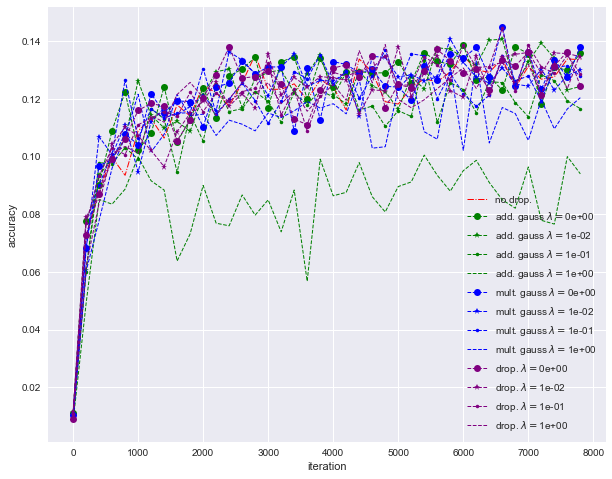

In [8]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()